In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from utilities import exposure_new, exposure_contour, read_ac_data, gdp_from_cdd_exposure

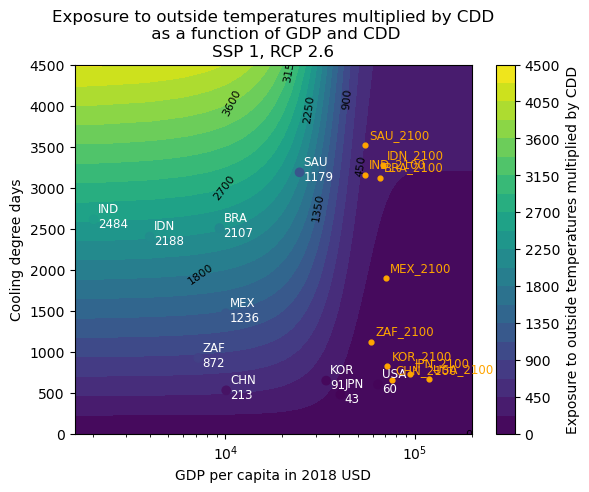

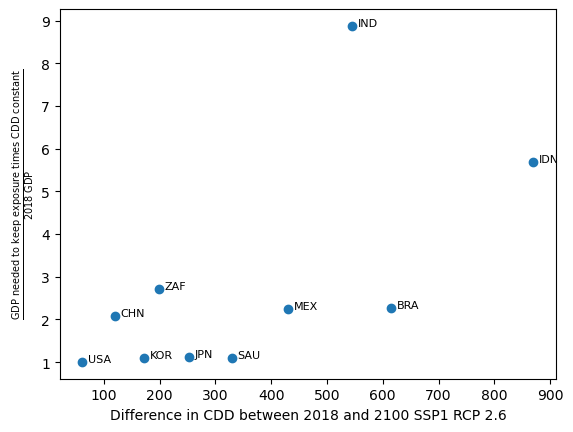

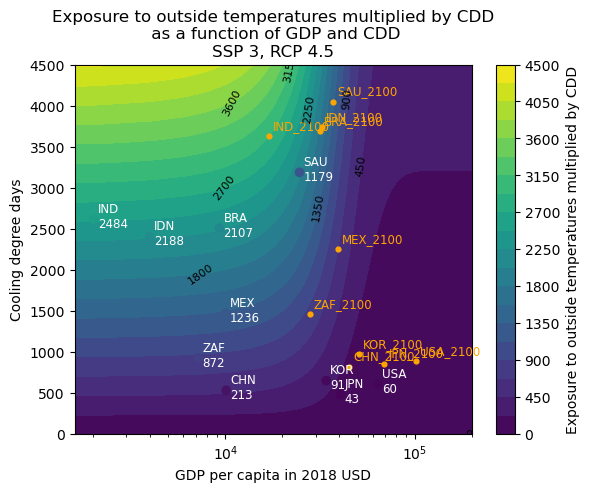

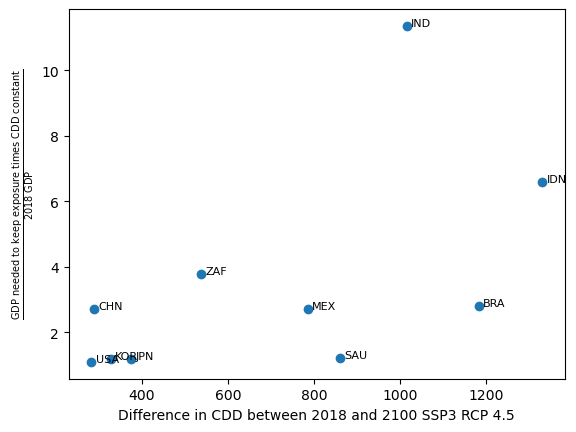

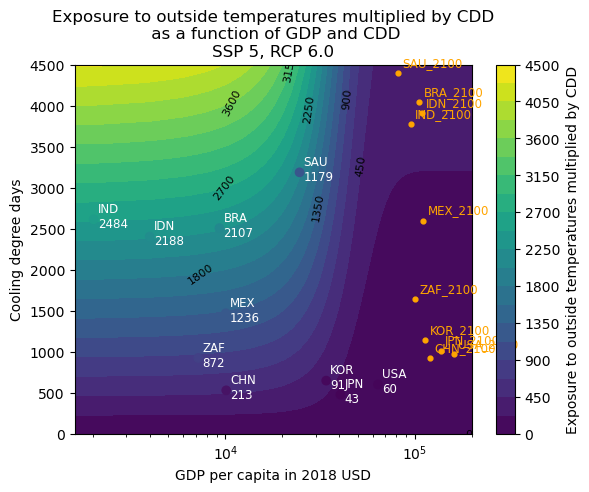

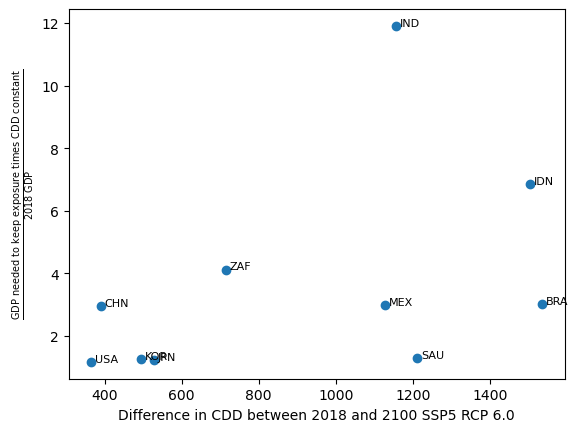

In [4]:
for ssp_rcp in ['1_26', '3_45', '5_60']:
    ssp = ssp_rcp.split('_')[0]
    rcp = ssp_rcp.split('_')[1]

    # Read in AC, GDP, DD data
    ac_data = read_ac_data('data_experiencedT/AC_data.csv')

    # Add predictions for DD_mean and GDP for the countries in ac_data
    # Read in data for countries in ac_data
    dd_projection = pd.read_csv('data_experiencedT/projections/ISO_CDD_GDP18_agg_data.csv')
    # Filter for SSP and RCP
    dd_projection = dd_projection.loc[(dd_projection['rcp'] == 'rcp{0}'.format(rcp)) & (dd_projection['ssp'] == 'SSP{0}'.format(ssp)) & (dd_projection['year'] == 2100) & (dd_projection['stat'] == 'mean')]
    # Filter to keep countries in ac_data
    dd_projection = dd_projection[dd_projection['ISO'].isin(ac_data['ISO3'])]
    # Rename ISO to ISO3
    dd_projection = dd_projection.rename(columns={'ISO': 'ISO3'})
    # Only keep ISO and value columns
    dd_projection = dd_projection[['ISO3', 'value']]
    # Rename value column to DD_mean
    dd_projection = dd_projection.rename(columns={'value': 'DD_mean'})
    dd_projection.set_index('ISO3', inplace=True)

    gdp_projection = pd.read_csv('data_experiencedT/projections/gdp_edu_projections.csv')
    # Filter for SSP and year 2100
    gdp_projection = gdp_projection.loc[(gdp_projection['scenario'] == 'SSP{0}'.format(ssp)) & (gdp_projection['year'] == 2100)]
    # Only keep countrycode and gdpcc columns
    gdp_projection = gdp_projection[['countrycode', 'gdppc']]
    # Only keep countries in ac_data
    gdp_projection = gdp_projection[gdp_projection['countrycode'].isin(ac_data['ISO3'])]
    # Rename countrycode to ISO
    gdp_projection = gdp_projection.rename(columns={'countrycode': 'ISO3'})

    # Merge the two dataframes
    merged_projections = pd.merge(dd_projection, gdp_projection, on='ISO3')
    # Add _2100 to ISO3 column
    merged_projections['ISO3'] = merged_projections['ISO3'] + '_2100'
    # Rename gdppc to GDP
    merged_projections = merged_projections.rename(columns={'gdppc': 'GDP'})

    # Add to ac_data without append
    ac_data = pd.concat([ac_data, merged_projections])
    # Reset index
    ac_data = ac_data.reset_index(drop=True)

    # Plot exposure contour
    exposure_contour(exposure_new, ac_data, multiply_cdd=True, contour_lines=True,
                    name_tag='exposure_contour_ssp_{0}_rcp_{1}'.format(ssp, rcp), future_scenario='\nSSP {0}, RCP {1}'.format(ssp, int(rcp)/10))
    

    # Compute change in experienced CDD compared to present (2018)
    
    # Copy ac_data to ac_data_new and only keep ISO3, DD_mean and GDP columns
    ac_data_new = ac_data[['ISO3', 'DD_mean', 'GDP']].copy()
    # Add column for exposure times CDD
    ac_data_new['exposure_times_cdd'] = exposure_new(ac_data_new['GDP'], ac_data_new['DD_mean'])*ac_data_new['DD_mean']
    # Split dataset into two: One with ISO3 without _2100 and one with ISO3 with _2100
    ac_data_new_2100 = ac_data_new[ac_data_new['ISO3'].str.contains('_2100')]
    ac_data_new = ac_data_new[~ac_data_new['ISO3'].str.contains('_2100')]
    ac_data_new['diff_exposure_times_cdd'] = ac_data_new_2100['exposure_times_cdd'].values - ac_data_new['exposure_times_cdd'].values
    ac_data_new['diff_cdd'] = ac_data_new_2100['DD_mean'].values - ac_data_new['DD_mean'].values

    # Calculate GDP needed to keep exposure times CDD constant
    ac_data_new['gdp_const'] = gdp_from_cdd_exposure(ac_data_new['exposure_times_cdd'], ac_data_new_2100['DD_mean']) / ac_data_new['GDP']

    # Plot difference in exposure times CDD as a function of GDP per capita
    plt.figure()
    # plt.scatter(ac_data_new['GDP'], ac_data_new['diff_exposure_times_cdd'], label='Difference in exposure times CDD', color='darkgreen')
    plt.scatter(ac_data_new['diff_cdd'], ac_data_new['gdp_const'])
    plt.xlabel('Difference in CDD between 2018 and 2100 SSP{0} RCP {1}'.format(ssp, int(rcp)/10))
    plt.ylabel(r'$\frac{ \mathrm{GDP \ needed \ to \ keep \ exposure \ times \ CDD \ constant}}{\mathrm{2018 \ GDP}}$')


    # Label each point with country name
    for i, txt in enumerate(ac_data_new['ISO3'].values):
        plt.annotate(txt, (ac_data_new['diff_cdd'][i]+10, ac_data_new['gdp_const'][i]), fontsize=8)
    # for i, txt in enumerate(ac_data_new['ISO3'].values):
    #     plt.annotate(txt, (ac_data_new['GDP'][i], ac_data_new['diff_exposure_times_cdd'][i]*1.05), fontsize=8)
    # plt.savefig('Figures/exposure_funct_analysis/diff_exposure`_times_cdd.png', dpi=300)
    plt.savefig('Figures/exposure_funct_analysis/gdp_const_ssp_{0}_rcp_{1}.png'.format(ssp, rcp), dpi=300)
